<a href="https://colab.research.google.com/github/JasaZnidar/Predvidenje-zmagovalca-vaterpolo/blob/homogen-classification-GCN-Mk.-3/Diplomska_naloga.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this model, the data surrounds N number of teams, where team with the lower index always wins.

The data is stored in a Heterogeneus graph.
A node is a team and it's feature is the average team statistic, which will be used in the complete model (shots, goals,...) - the statistic that will be used here is goals, shots, shots saved

The stats for each team will be calculated as follows:

  * Shots: Values will be linearly disperst on the following scale: [log_1.05(number of teams), 5]

  * Goals: Goals are calculated by using a linear scale of [0.9, 0.1] to represent the percantage of successfull shots (calculated by using the teams shots)

  * Saves: Saves are calculated by using a linear scale of [0.9, 0.1] to represent the percantage of the average shots made

An edge represents a match. For each match there are 2 edges. It represents the result, from the originating node teams point of view. Meaning that if the number is negative, they lost. The absolute value is the difference in gols. This value is also used as a weight for the edges during learning.

To predict the result, we use a GCN evalueate all teams, concatinate these evaluations in acordance with the edge we are trying to predict (originating node team is first) and then do a linear regression to get a single value, which is the result.

# Setup

## Download whl-s and requirements

In [ ]:
import urllib.request

urllib.request.urlretrieve("https://raw.githubusercontent.com/JasaZnidar/Predvidenje-zmagovalca-vaterpolo/refs/heads/main/requirements.txt", "requirements.txt")

('requirements.txt', <http.client.HTTPMessage at 0x7b8751c03d60>)

## pip

In [ ]:
!sudo apt-get install libcairo2-dev pkg-config python3-dev
!pip install --upgrade pip
!pip install --force-reinstall --no-cache-dir pycairo

!pip install -q -r requirements.txt

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libcairo2-dev is already the newest version (1.16.0-5ubuntu2).
pkg-config is already the newest version (0.29.2-1ubuntu3).
python3-dev is already the newest version (3.10.6-1~22.04.1).
The following packages were automatically installed and are no longer required:
  libbz2-dev libpkgconf3 libreadline-dev
Use 'sudo apt autoremove' to remove them.
0 upgraded, 0 newly installed, 0 to remove and 47 not upgraded.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 661.5/661.5 kB 182.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pycairo: filename=pycairo-1.27.0-cp310-cp310-linux_x86_64.whl size=128157 sha256=54091d3056fb58dbda96549c035e8b325b74832592c1c6660d633a228b9b6614
  Stored in directory: /tmp/pip-ephem-wheel-cache-ay41dym2/whee

# Imports

In [ ]:
import json
import networkx as nx
import torch
import torch.nn.functional as F
import torch_geometric
from torch_geometric.utils.convert import from_networkx
from torch_geometric import nn, sampler
from torch_geometric.data import HeteroData, Data
from torch_geometric import transforms as T
from torch_geometric import loader
from torcheval import metrics as M
from torcheval.metrics import R2Score, MeanSquaredError
import tqdm
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import requests
from zipfile import ZipFile
from math import log
%matplotlib inline

# Data definition

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

win_value = 1.0
loss_value = -1.0
tie_value = (win_value + loss_value)/2

numTrainMatchCycles = 10
numValMatchCycles = 3
numOfTeams = 25
cycleSize = int((numOfTeams*(numOfTeams - 1))/2)

max_shots = log(numOfTeams, 1.05)
min_shots = 5

def shots(X: int) -> float:
  x = float(X)

  return ((min_shots - max_shots)/(numOfTeams - 1))*x + max_shots

def goals(X: int) -> float:
  x = float(X)
  rate = (-0.8/(numOfTeams - 1))*x + 0.9
  shot = shots(X)

  return rate * shot

def saves(X: int) -> float:
  x = float(X)
  rate = (-0.8/(numOfTeams - 1))*x + 0.9
  shot = (max_shots + min_shots)/2

  return rate * shot

cycle = [
    [],
    []
]
result = []

for i in range(numOfTeams):
  for j in range(i+1, numOfTeams):
    cycle[0].append(i)
    cycle[0].append(j)
    result.append(goals(j) - goals(i))
    cycle[1].append(j)
    cycle[1].append(i)
    result.append(goals(i) - goals(j))

# Learning

In [ ]:
epochs = 500

lr = 0.01
dropout_p = 0.0
Diff = True
Tie = True
crit = torch.nn.MSELoss()

# Data: team A always wins

In [ ]:
data = Data()
data.x = torch.Tensor(
    [[shots(i), goals(i), saves(i)] for i in range(numOfTeams)]
)
data.edge_index = torch.Tensor(
    [cycle[0]*(numTrainMatchCycles + numValMatchCycles),
     cycle[1]*(numTrainMatchCycles + numValMatchCycles)]
).type(torch.long)
data.edge_attr = torch.Tensor(
    [[win_value, loss_value]*cycleSize*(numTrainMatchCycles + numValMatchCycles)]
)
data.edge_weight = torch.abs(torch.Tensor(
    result*(numTrainMatchCycles + numValMatchCycles)
))

data.train_mask = torch.Tensor(
    [[True]*2*cycleSize*numTrainMatchCycles + [False]*2*cycleSize*numValMatchCycles]
).type(torch.bool)
data.val_mask = torch.Tensor(
    [[False]*2*cycleSize*numTrainMatchCycles + [True]*2*cycleSize*numValMatchCycles]
).type(torch.bool)

In [ ]:
def plotLoss(loss_data: list[float]):
  plt.plot(range(len(loss_data)), loss_data)
  plt.show()

# Model

In [ ]:
class model(torch.nn.Module):
  def __init__(self, channels: list[int], device: str='cpu', dropout: float=0.0):
    assert len(channels) >= 2

    super().__init__()

    self.device = device
    self.dropout = dropout

    self.gcn = torch.nn.ModuleList()
    for i in range(len(channels) - 1):
      self.gcn.append(nn.GCNConv(channels[i], channels[i+1], add_self_loops=False))
    self.gcn.to(self.device)

    self.lin = torch.nn.Linear(channels[-1]*2, 1).to(self.device)

  def forward(self, x: torch.Tensor, edge_index: torch.Tensor, edge_weight: torch.Tensor) -> torch.Tensor:
    # move data to device
    x = x.to(self.device)
    edge_index = edge_index.to(self.device)
    edge_weight = edge_weight.to(self.device)

    # calculate values for each team
    for module in self.gcn:
      x = module(x, edge_index, edge_weight)
      x = x.relu()
      x = F.dropout(x, p=self.dropout, training=self.training)

    # create match vectors by combining teams that played
    x_1st = x[edge_index[0]]
    x_2nd = x[edge_index[1]]
    lin_input = torch.cat((x_1st, x_2nd), dim=1)

    # calculate result from match vector
    x = self.lin(lin_input)

    return x.T

# Learn

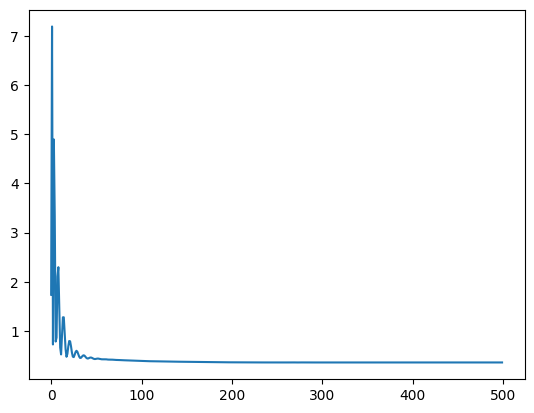

In [ ]:
gcn = model([3] + [numOfTeams*2]*1 + [numOfTeams*1], device=device, dropout=dropout_p)
gcn.to(device)
optimizer = torch.optim.Adam(gcn.parameters(), lr=lr)

loss_values = []

for epoch in range(epochs):
  # prepare model for training
  gcn.train()
  optimizer.zero_grad()

  # prepare train data
  train_mask = torch.reshape(data.train_mask, (-1,))
  x = data.x
  edge_index = data.edge_index[:, train_mask]
  edge_weight = data.edge_weight[train_mask]

  # train
  pred = gcn(x, edge_index, edge_weight).to(device)

  # prepare validation data
  ground_truth = data.edge_attr[:, train_mask].to(device)
  ground_truth.requires_grad = True

  # calculate loss
  loss = crit(pred, ground_truth)
  loss_values.append(loss.item())
  loss.backward()
  optimizer.step()

# draw loss
plotLoss(loss_values)

# Evaluate

In [ ]:
gcn.eval()

val_mask = torch.reshape(data.val_mask, (-1,))
x = data.x
edge_index = data.edge_index[:, val_mask]
edge_weight = data.edge_weight[val_mask]

pred = gcn(x, edge_index, edge_weight).to(device).T
class_pred = (torch.where(pred >= tie_value, win_value, loss_value) + 1)/2

ground_truth = data.edge_attr[:, val_mask].to(device).T
ground_truth.requires_grad = True
class_ground_truth = (ground_truth + 1)/2

R2 = M.R2Score()
R2.to(device)
R2.update(pred, ground_truth)
print(f"R2: {R2.compute()}")

MSE = M.MeanSquaredError()
MSE.to(device)
MSE.update(pred, ground_truth)
print(f"MSE: {MSE.compute()}")

BiAcc = M.BinaryAccuracy()
BiAcc.to(device)
BiAcc.update(torch.reshape(class_pred, (-1,)), torch.reshape(class_ground_truth, (-1,)))
print(f"BiAcc: {BiAcc.compute()}")

R2: 0.6436153054237366
MSE: 0.3563846945762634
BiAcc: 0.9599999785423279
